In [1]:
!pip install dask
!pip install dask[dataframe]
!pip install soundfile


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
zsh:1: no matches found: dask[dataframe]
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [95]:
import os
import dask.dataframe as dd
import soundfile as sf
import numpy as np
import pandas as pd
from dask import delayed

In [96]:
# obtaining the path to the dev_clean directory
dev_clean_dir = os.path.expanduser('dev-clean/')

In [97]:
pwd

'/Users/sarveswararaopatchipulusu/Documents/dataset_speech'

In [98]:
# FLAC file and extract features
def extract_features(file_path):
    data, samplerate = sf.read(file_path)
    # Example feature: mean of the audio signal
    mean_signal = np.mean(data)
    return pd.DataFrame({'file_path': [file_path], 'mean_signal': [mean_signal]})

In [99]:
# Function to recursively gather all FLAC files
def get_flac_file_paths(root_dir):
    flac_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.flac'):
                flac_files.append(os.path.join(dirpath, filename))
    return flac_files

In [100]:
# Function to get all file paths in a directory
def get_all_file_paths(root_dir):
    file_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths


In [101]:
# list of all file paths
all_file_paths = get_all_file_paths(dev_clean_dir)
print(f"Total files found: {len(all_file_paths)}")


Total files found: 2833


In [102]:
# list of FLAC file paths
file_paths = get_flac_file_paths(dev_clean_dir)


In [103]:
# Using Dask delayed to handle the out-of-core computation
delayed_results = [delayed(extract_features)(file_path) for file_path in file_paths]
dask_df = dd.from_delayed(delayed_results)


In [104]:
# Performing the computation and load into a Dask dataframe
df = dask_df.compute()
print(df.head())

                                     file_path  mean_signal
0  dev-clean/2412/153954/2412-153954-0019.flac    -0.000101
0  dev-clean/2412/153954/2412-153954-0023.flac    -0.000118
0  dev-clean/2412/153954/2412-153954-0015.flac    -0.000081
0  dev-clean/2412/153954/2412-153954-0003.flac    -0.000088
0  dev-clean/2412/153954/2412-153954-0002.flac    -0.000097


In [105]:
!pip install librosa numpy pandas matplotlib seaborn


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [106]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

In [107]:
%matplotlib inline


In [122]:
def aggregate_audio_data(directory):
    mfccs_list = []
    chroma_list = []
    zcr_list = []
    durations = []
    centroid_list = []
    bandwidth_list = []

    for folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".flac"):
                file_path = os.path.join(folder, file)
                y, sr = librosa.load(file_path)

                # Extract MFCCs
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfccs_mean = np.mean(mfccs, axis=1)
                mfccs_list.append(mfccs_mean)

                # Extract chroma features
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                chroma_mean = np.mean(chroma, axis=1)
                chroma_list.append(chroma_mean)

                # Extract zero-crossing rate
                zcr = librosa.feature.zero_crossing_rate(y)
                zcr_mean = np.mean(zcr)
                zcr_list.append(zcr_mean)
                
                # Extract spectral centroid
                centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                centroid_mean = np.mean(centroid)
                centroid_list.append(centroid_mean)

                # Extract spectral bandwidth
                bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                bandwidth_mean = np.mean(bandwidth)
                bandwidth_list.append(bandwidth_mean)

                # Extract duration
                duration = librosa.get_duration(y=y, sr=sr)
                durations.append(duration)

    # Converting to DataFrame
    data = pd.DataFrame(mfccs_list, columns=[f'MFCC{i+1}' for i in range(13)])
    data[['Chroma' + str(i+1) for i in range(12)]] = pd.DataFrame(chroma_list)
    data['Zero Crossing Rate'] = zcr_list
    data['Duration'] = durations
    data['Spectral Centroid'] = centroid_list
    data['Spectral Bandwidth'] = bandwidth_list

    return data

In [123]:
def visualize_data(data):
    # Summary statistics of MFCCs
    print("Summary statistics of MFCCs:")
    print(data.iloc[:, :13].describe())
    print()

    # Correlation heatmap of MFCCs
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.iloc[:, :13].corr(), annot=True,fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of MFCCs')
    plt.show()

    # Boxplots of MFCCs
    plt.figure(figsize=(12, 6))
    data.iloc[:, :13].boxplot()
    plt.title('Boxplots of MFCCs')
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Values')
    plt.show()

    # Distribution of Chroma Features
    plt.figure(figsize=(12, 6))
    data.iloc[:, 13:25].boxplot()
    plt.title('Boxplots of Chroma Features')
    plt.xlabel('Chroma Features')
    plt.ylabel('Values')
    plt.show()

    # Histogram of Zero Crossing Rate
    plt.figure(figsize=(8, 6))
    plt.hist(data['Zero Crossing Rate'], bins=20,color='skyblue', edgecolor='black')
    plt.title('Histogram of Zero Crossing Rate')
    plt.xlabel('Zero Crossing Rate')
    plt.ylabel('Frequency')
    plt.show()

    # Histogram of audio durations
    plt.figure(figsize=(8, 6))
    plt.hist(data['Duration'], bins=20, color='skyblue',edgecolor='black')
    plt.title('Histogram of Audio Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.show()
    
    
    # Histogram of Spectral Centroid
    plt.figure(figsize=(8, 6))
    plt.hist(data['Spectral Centroid'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Spectral Centroid')
    plt.xlabel('Spectral Centroid')
    plt.ylabel('Frequency')
    plt.show()

    # Histogram of Spectral Bandwidth
    plt.figure(figsize=(8, 6))
    plt.hist(data['Spectral Bandwidth'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Spectral Bandwidth')
    plt.xlabel('Spectral Bandwidth')
    plt.ylabel('Frequency')
    plt.show()

Summary statistics of MFCCs:
             MFCC1        MFCC2        MFCC3        MFCC4        MFCC5  \
count  2703.000000  2703.000000  2703.000000  2703.000000  2703.000000   
mean   -351.145325   112.392479   -19.559353    36.313122    -9.416766   
std      48.718941    18.141512    20.988983    14.516722    10.408020   
min    -580.053528    54.307858  -102.794884   -18.908312   -41.640476   
25%    -377.058746    99.728233   -29.466619    26.365400   -16.216422   
50%    -347.162537   112.398865   -17.225967    36.907017    -9.395995   
75%    -321.976852   124.079506    -5.056928    46.190542    -2.364258   
max    -160.044373   180.308228    24.067759    86.241547    23.166492   

             MFCC6        MFCC7        MFCC8        MFCC9       MFCC10  \
count  2703.000000  2703.000000  2703.000000  2703.000000  2703.000000   
mean      7.201278   -12.212033    -2.474883    -8.493014     0.297690   
std      15.389721    10.076823    10.058705     7.250594     5.615866   
min     

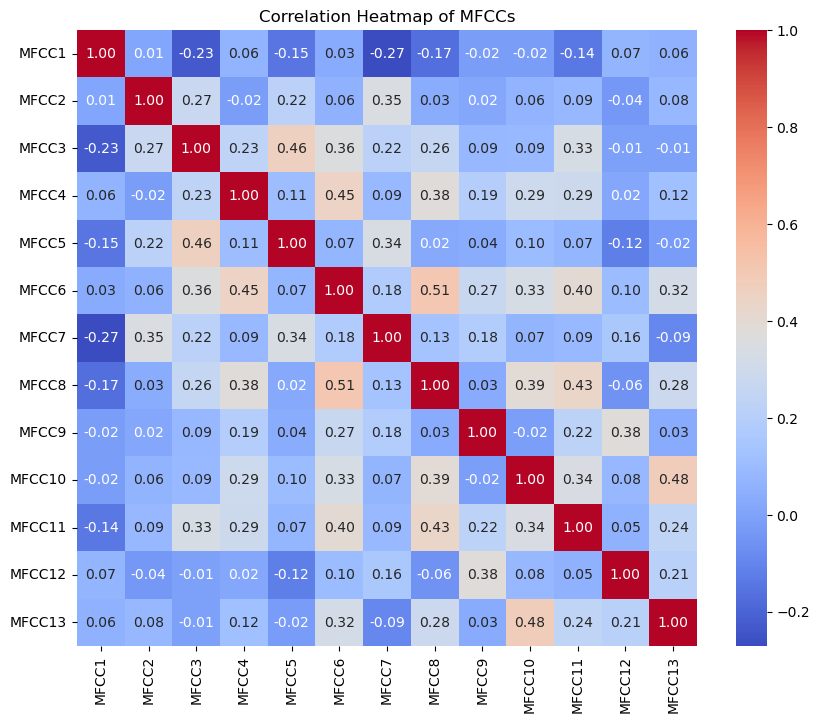

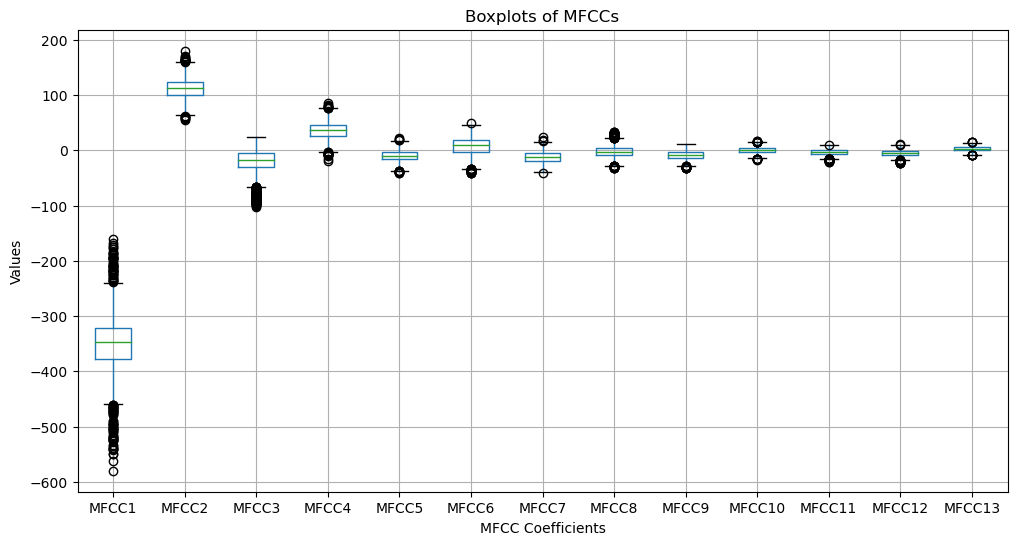

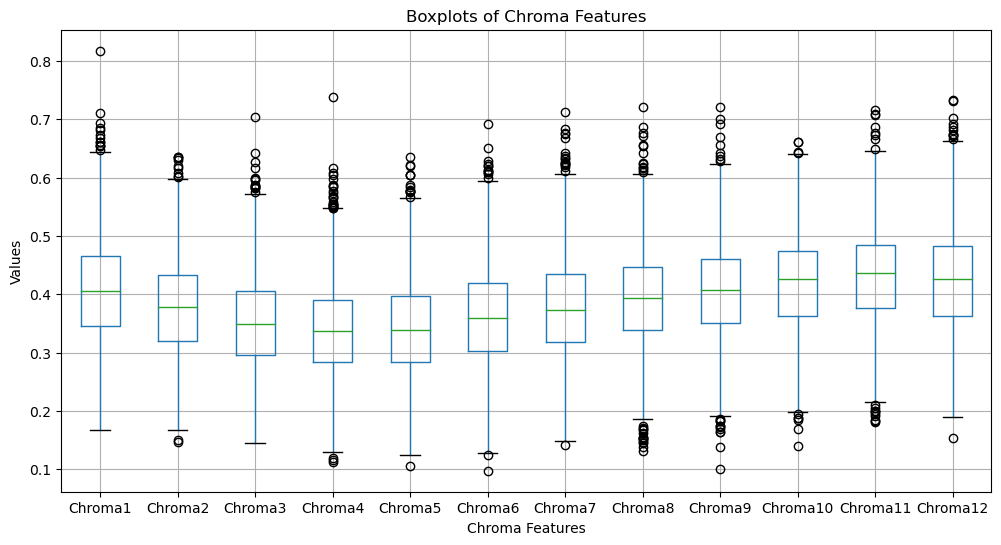

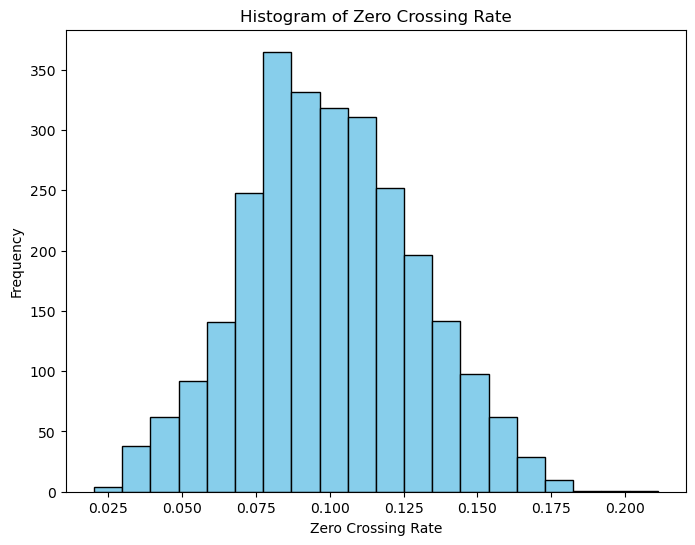

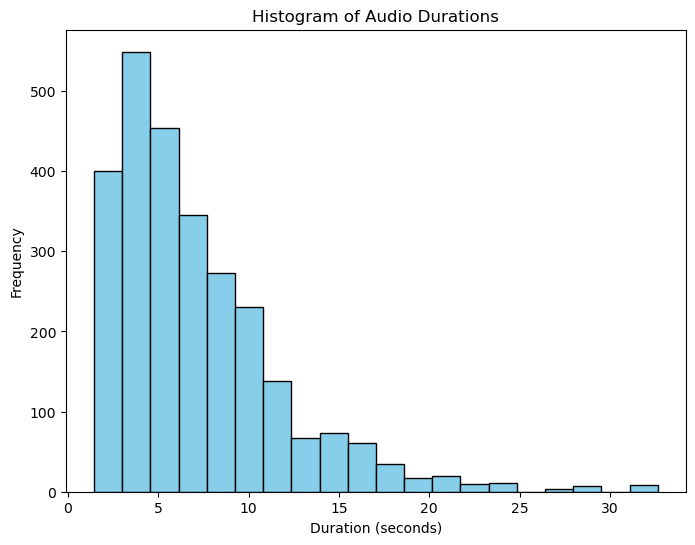

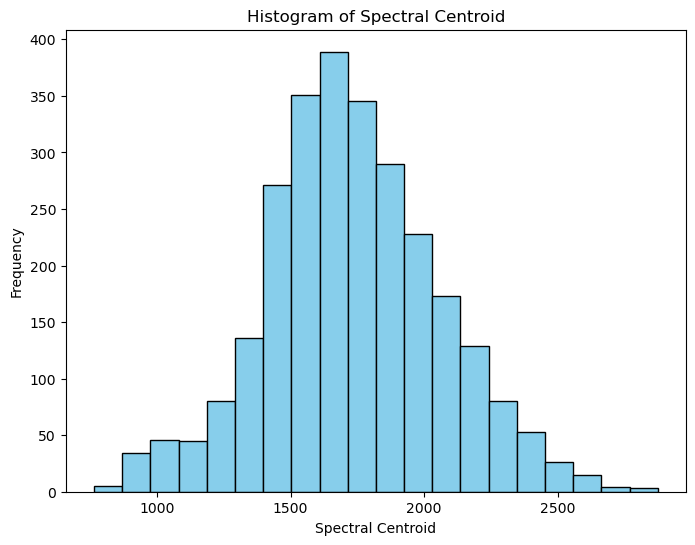

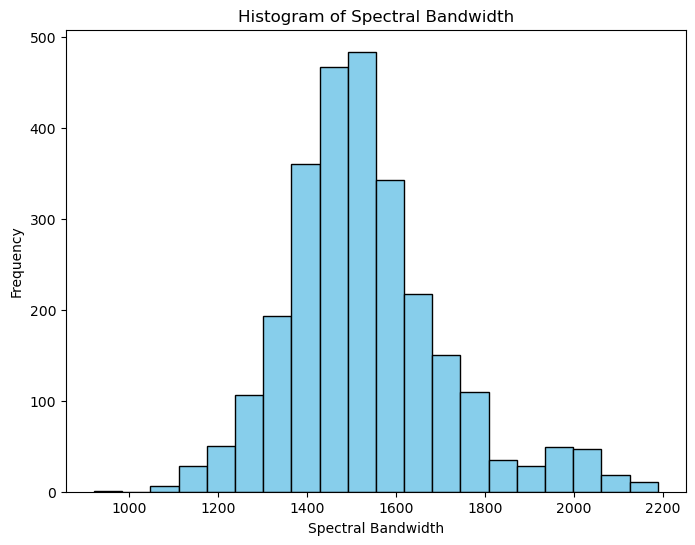

In [124]:
if __name__ == "__main__":
    

    # Aggregating audio data
    audio_data = aggregate_audio_data(dev_clean_dir)

    # Visualizing the aggregated data
    visualize_data(audio_data)